In [166]:
import h2o
from h2o.automl import H2OAutoML
import random, os, sys
from datetime import datetime
import pandas as pd
import logging
import numpy as np
import csv
import optparse
import time
import json
from distutils.util import strtobool
import psutil
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.grid.grid_search import H2OGridSearch
import matplotlib.pyplot as plt

In [4]:
data_path=None
all_variables=None
test_path=None
# target='search_term'
target=None
nthreads=1 
min_mem_size=6 
run_time=100
classification=False
scale=False
max_models=100    
model_path=None
balance_y=False 
balance_threshold=0.2
name=None 
server_path=None  
analysis=0


In [5]:
#Funtion for meta data
def set_meta_data(analysis,run_id,server,data,test,model_path,target,run_time,classification,scale,model,balance,
                  balance_threshold,name,path,nthreads,min_mem_size):
  m_data={}
  m_data['start_time'] = time.time()
  m_data['target']=target
  m_data['server_path']=server
  m_data['data_path']=data 
  m_data['test_path']=test
  m_data['max_models']=model
  m_data['run_time']=run_time
  m_data['run_id'] =run_id
  m_data['scale']=scale
  m_data['classification']=classification
  m_data['scale']=False
  m_data['model_path']=model_path
  m_data['balance']=balance
  m_data['balance_threshold']=balance_threshold
  m_data['project'] =name
  m_data['end_time'] = time.time()
  m_data['execution_time'] = 0.0
  m_data['run_path'] =path
  m_data['nthreads'] = nthreads
  m_data['min_mem_size'] = min_mem_size
  m_data['analysis'] = analysis
 
  return m_data




In [6]:
#Function to convert dictionary into json file
def dict_to_json(dct,n):
  j = json.dumps(dct, indent=4)
  f = open(n, 'w')
  print(j, file=f)
  f.close()
    
#Function for random alphabet   
def alphabet(n):
  alpha='0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ'    
  str=''
  r=len(alpha)-1   
  while len(str)<n:
    i=random.randint(0,r)
    str+=alpha[i]   
  return str

def impute_missing_values(df, x, scal=False):
    # determine column types
    ints, reals, enums = [], [], []
    for key, val in df.types.items():
        if key in x:
            if val == 'enum':
                enums.append(key)
            elif val == 'int':
                ints.append(key)            
            else: 
                reals.append(key)    
    _ = df[reals].impute(method='mean')
    _ = df[ints].impute(method='median')
    if scal:
        df[reals] = df[reals].scale()
        df[ints] = df[ints].scale()    
    return


    

def predictions(mod,data,run_id):
    test = h2o.import_file(data)
    mod_perf=mod_best.model_performance(test)
              
    stats_test={}
    stats_test=model_performance_stats(mod_perf)

    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 

    try:    
      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf[0].table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass

    predictions = mod_best.predict(test)
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

def check_X(x,df):
    for name in x:
        if name not in df.columns:
          x.remove(name)  
    return x    
    
    
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val
    return d    

In [7]:
def se_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id  
    d['auc']=modl.auc()   
    d['roc']=modl.roc()
    d['mse']=modl.mse()   
    d['null_degrees_of_freedom']=modl.null_degrees_of_freedom()
    d['null_deviance']=modl.null_deviance()
    d['residual_degrees_of_freedom']=modl.residual_degrees_of_freedom()   
    d['residual_deviance']=modl.residual_deviance()
    d['rmse']=modl.rmse()
    return d

def get_model_by_algo(algo,models_dict):
    mod=None
    mod_id=None    
    for m in list(models_dict.keys()):
        if m[0:3]==algo:
            mod_id=m
            mod=h2o.get_model(m)      
    return mod,mod_id     
    
    

In [8]:
def stackedensemble(mod):
    coef_norm=None
    try:
      metalearner = h2o.get_model(mod.metalearner()['name'])
      coef_norm=metalearner.coef_norm()
    except:
      pass        
    return coef_norm

def stackedensemble_df(df):
    bm_algo={ 'GBM': None,'GLM': None,'DRF': None,'XRT': None,'Dee': None}
    for index, row in df.iterrows():
      if len(row['model_id'])>3:
        key=row['model_id'][0:3]
        if key in bm_algo:
          if bm_algo[key] is None:
                bm_algo[key]=row['model_id']
    bm=list(bm_algo.values()) 
    bm=list(filter(None.__ne__, bm))             
    return bm


def gbm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    
    
def dl_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    return d
    

In [9]:
def drf_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()     
    return d
    
def xrt_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['varimp']=modl.varimp()  
    d['roc']=modl.roc()      
    return d
    
    
def glm_stats(modl):
    d={}
    d['algo']=modl.algo
    d['model_id']=modl.model_id   
    d['coef']=modl.coef()  
    d['coef_norm']=modl.coef_norm()      
    return d

In [10]:

    
def model_performance_stats(perf):
    d={}
    try:    
      d['mse']=perf.mse()
    except:
      pass      
    try:    
      d['rmse']=perf.rmse() 
    except:
      pass      
    try:    
      d['null_degrees_of_freedom']=perf.null_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_degrees_of_freedom']=perf.residual_degrees_of_freedom()
    except:
      pass      
    try:    
      d['residual_deviance']=perf.residual_deviance() 
    except:      pass      
    try:    
      d['null_deviance']=perf.null_deviance() 
    except:
      pass      
    try:    
      d['aic']=perf.aic() 
    except:
      pass      
    try:
      d['logloss']=perf.logloss() 
    except:
      pass    
    try:
      d['auc']=perf.auc()
    except:
      pass  
    try:
      d['gini']=perf.gini()
    except:
      pass    
    return d

In [11]:
all_variables=None

In [12]:
data_path='C:/Users/pkash/Downloads/adult.csv'

In [13]:
run_id=alphabet(9)
if server_path==None:
    server_path=os.path.abspath(os.curdir)
os.chdir(server_path) 
run_dir = os.path.join(server_path,run_id)
os.mkdir(run_dir)
os.chdir(run_dir)    

# run_id to std out
print (run_id)

mObOrqIpy


In [14]:
##For logs
logfile=run_id+'_autoh2o_log.zip'
logs_path=os.path.join(run_dir,'logs')
print(logs_path,' ',logfile)

C:\Users\pkash\mObOrqIpy\logs   mObOrqIpy_autoh2o_log.zip


In [15]:
h2o.init(ip="localhost", port=54323)

Checking whether there is an H2O instance running at http://localhost:54323 ..... not found.
Attempting to start a local H2O server...
; Java HotSpot(TM) 64-Bit Server VM (build 25.201-b09, mixed mode)
  Starting server from C:\Users\pkash\Anaconda\lib\site-packages\h2o\backend\bin\h2o.jar
  Ice root: C:\Users\pkash\AppData\Local\Temp\tmpkrfxo9ep
  JVM stdout: C:\Users\pkash\AppData\Local\Temp\tmpkrfxo9ep\h2o_pkash_started_from_python.out
  JVM stderr: C:\Users\pkash\AppData\Local\Temp\tmpkrfxo9ep\h2o_pkash_started_from_python.err
  Server is running at http://127.0.0.1:54323
Connecting to H2O server at http://127.0.0.1:54323 ... successful.


H2O cluster uptime:,05 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.24.0.1
H2O cluster version age:,19 days
H2O cluster name:,H2O_from_python_pkash_psun55
H2O cluster total nodes:,1
H2O cluster free memory:,1.743 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


In [16]:
# meta data
meta_data = set_meta_data(analysis, run_id,server_path,data_path,test_path,model_path,target,run_time,classification,scale,max_models,balance_y,balance_threshold,name,run_dir,nthreads,min_mem_size)
print(meta_data)

{'start_time': 1555767122.059894, 'target': None, 'server_path': 'C:\\Users\\pkash', 'data_path': 'C:/Users/pkash/Downloads/adult.csv', 'test_path': None, 'max_models': 100, 'run_time': 100, 'run_id': 'mObOrqIpy', 'scale': False, 'classification': False, 'model_path': None, 'balance': False, 'balance_threshold': 0.2, 'project': None, 'end_time': 1555767122.059894, 'execution_time': 0.0, 'run_path': 'C:\\Users\\pkash\\mObOrqIpy', 'nthreads': 1, 'min_mem_size': 6, 'analysis': 0}


In [17]:
df = h2o.import_file(data_path)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [18]:
df.head()

age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K
38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K
28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K
44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K
18,?,103497,Some-college,10,Never-married,?,Own-child,White,Female,0,0,30,United-States,<=50K
34,Private,198693,10th,6,Never-married,Other-service,Not-in-family,White,Male,0,0,30,United-States,<=50K
29,?,227026,HS-grad,9,Never-married,?,Unmarried,Black,Male,0,0,40,United-States,<=50K
63,Self-emp-not-inc,104626,Prof-school,15,Married-civ-spouse,Prof-specialty,Husband,White,Male,3103,0,32,United-States,>50K
24,Private,369667,Some-college,10,Never-married,Other-service,Unmarried,White,Female,0,0,40,United-States,<=50K
55,Private,104996,7th-8th,4,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,10,United-States,<=50K


In [19]:

df.describe()
# shows that there is no missing values in the data

Rows:48842
Cols:15




,age,workclass,fnlwgt,education,educational-num,marital-status,occupation,relationship,race,gender,capital-gain,capital-loss,hours-per-week,native-country,income
type,int,enum,int,enum,int,enum,enum,enum,enum,enum,int,int,int,enum,enum
mins,17.0,,12285.0,,1.0,,,,,,0.0,0.0,1.0,,
mean,38.643585438761704,,189664.13459727284,,10.078088530363212,,,,,,1079.0676262233324,87.50231358257237,40.42238237582409,,
maxs,90.0,,1490400.0,,16.0,,,,,,99999.0,4356.0,99.0,,
sigma,13.710509934443555,,105604.02542315728,,2.570972755592256,,,,,,7452.019057655393,403.00455212435907,12.391444024252307,,
zeros,0,,0,,0,,,,,,44807,46560,0,,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,25.0,Private,226802.0,11th,7.0,Never-married,Machine-op-inspct,Own-child,Black,Male,0.0,0.0,40.0,United-States,<=50K
1,38.0,Private,89814.0,HS-grad,9.0,Married-civ-spouse,Farming-fishing,Husband,White,Male,0.0,0.0,50.0,United-States,<=50K
2,28.0,Local-gov,336951.0,Assoc-acdm,12.0,Married-civ-spouse,Protective-serv,Husband,White,Male,0.0,0.0,40.0,United-States,>50K


In [27]:
# split into training and test 
train, test = df.split_frame([0.6])

In [28]:
# dependent variable
# assign target and inputs for classification or regression
if target==None:
    target=train.columns[14]   
y = target
y

'income'

In [29]:
x = list(train.columns)
x.remove(y)
x
# Add independent variables

meta_data['x']=x 
# impute missing values

#_=impute_missing_values(df,x, scale)


In [30]:
# # impute missing values

# _ = df[ints].impute(method='median')

# if scale:
    
#     df[ints] = df[ints].scale()

In [31]:
if analysis == 3:
  classification=False
elif analysis == 2:
  classification=True
elif analysis == 1:
  classification=True

In [32]:
def check_y(y,df):
  ok=False
  C = [name for name in df.columns if name == y]
  for key, val in df.types.items():
    if key in C:
      if val in ['real','int','enum']:        
        ok=True         
  return ok

In [33]:
ok=check_y(y,df)
if not ok:
    print(ok)

In [34]:
classification=True
if classification:
    print(df[y].levels())

[['<=50K', '>50K']]


In [35]:
def get_variables_types(df):
    d={}
    for key, val in df.types.items():
        d[key]=val           
    return d    

In [38]:
allV=get_variables_types(train)
allV

{'age': 'int',
 'workclass': 'enum',
 'fnlwgt': 'int',
 'education': 'enum',
 'educational-num': 'int',
 'marital-status': 'enum',
 'occupation': 'enum',
 'relationship': 'enum',
 'race': 'enum',
 'gender': 'enum',
 'capital-gain': 'int',
 'capital-loss': 'int',
 'hours-per-week': 'int',
 'native-country': 'enum',
 'income': 'enum'}

In [39]:
meta_data['variables']=allV


In [40]:
# Set up AutoML

aml = H2OAutoML(max_runtime_secs=run_time,project_name = name)

In [41]:
model_start_time = time.time()

In [42]:
aml.train(x=x,y=y,training_frame=df)

AutoML progress: |████████████████████████████████████████████████████████| 100%


In [45]:
meta_data['model_execution_time'] = time.time() - model_start_time

In [46]:
# get leaderboard
aml_leaderboard_df=aml.leaderboard.as_data_frame()

In [47]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_095656,0.928698,0.277266,0.175140,0.296459,0.087888
1,GBM_1_AutoML_20190420_095656,0.928689,0.277315,0.172812,0.296388,0.087846
2,StackedEnsemble_AllModels_AutoML_20190420_095656,0.928677,0.294438,0.178058,0.300674,0.090405
3,StackedEnsemble_BestOfFamily_AutoML_20190420_0...,0.927823,0.295471,0.173396,0.301184,0.090712
4,GBM_3_AutoML_20190420_095656,0.925760,0.286964,0.172997,0.299360,0.089617
5,GBM_4_AutoML_20190420_095656,0.918210,0.359341,0.180514,0.329490,0.108564
6,DRF_1_AutoML_20190420_095656,0.916764,0.309574,0.177295,0.307251,0.094403
7,GLM_grid_1_AutoML_20190420_095656_model_1,0.906625,0.318479,0.197486,0.319092,0.101820
8,GBM_5_AutoML_20190420_095656,0.878062,0.514214,0.212459,0.410379,0.168411


In [48]:
# STart best model as first model

model_set=aml_leaderboard_df['model_id']
mod_best=h2o.get_model(model_set[0])

In [49]:
mod_best._id


'GBM_2_AutoML_20190420_095656'

In [53]:
#To check the hyperparamter values for best model and saving it 
m= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,m)

In [54]:
# Get stacked ensemble  
def get_stacked_ensemble(lst):
    se=None
    for model in model_set:
      if 'BestOfFamily' in model:
        se=model
    if se is None:     
      for model in model_set:
        if 'AllModels'in model:
          se=model           
    return se       
    
se=get_stacked_ensemble(model_set)

In [55]:
print(se)

StackedEnsemble_BestOfFamily_AutoML_20190420_095656


In [60]:
if se is not None:
  mod_best=h2o.get_model(se)
mod_best._id

'StackedEnsemble_BestOfFamily_AutoML_20190420_095656'

In [ ]:
mod_best._get_metrics

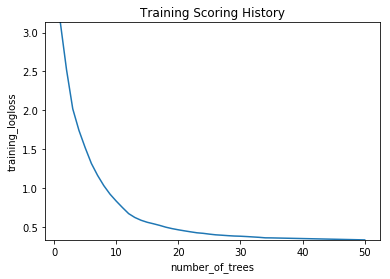

In [72]:
#HDP plot for DRF
mod_best.plot()

In [66]:
mods=mod_best.coef_norm
print(mods)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190420_095656


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09519372148223121
RMSE: 0.308534797846582
LogLoss: 0.3357584043256337
Mean Per-Class Error: 0.1720787740179044
AUC: 0.9144059496421585
pr_auc: 0.7012190115315191
Gini: 0.828811899284317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36837752074638763: 


,<=50K,>50K,Error,Rate
<=50K,32630.0,4525.0,0.1218,(4525.0/37155.0)
>50K,2833.0,8854.0,0.2424,(2833.0/11687.0)
Total,35463.0,13379.0,0.1506,(7358.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3683775,0.7064550,215.0
max f2,0.1693646,0.7887954,302.0
max f0point5,0.5914927,0.7466136,132.0
max accuracy,0.5414626,0.8659760,148.0
max precision,0.9834013,0.9967320,7.0
max recall,0.0000058,1.0,399.0
max specificity,0.9999780,0.9998654,0.0
max absolute_mcc,0.4805787,0.6135799,170.0
max min_per_class_accuracy,0.2928507,0.8267528,247.0
max mean_per_class_accuracy,0.2521932,0.8279212,266.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.22 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0223988,1.0,4.1600730,4.1600730,0.9954296,1.0,0.9954296,1.0,0.0931805,0.0931805,316.0073014,316.0073014
,2,0.0300152,0.9871138,4.1791734,4.1649198,1.0,0.9949620,0.9965894,0.9987216,0.0318302,0.1250107,317.9173441,316.4919779
,3,0.0400066,0.9479167,4.1020985,4.1492305,0.9815574,0.9667378,0.9928352,0.9907338,0.0409857,0.1659964,310.2098521,314.9230540
,4,0.0500594,0.9166667,3.9919192,4.1176396,0.9551935,0.9340554,0.9852761,0.9793518,0.0401301,0.2061265,299.1919233,311.7639599
,5,0.1000164,0.7586033,3.4752225,3.7967598,0.8315574,0.8329725,0.9084954,0.9062371,0.1736117,0.3797382,247.5222504,279.6759822
,6,0.1500143,0.6231996,2.8477251,3.4804581,0.6814087,0.6901180,0.8328102,0.8342072,0.1423804,0.5221186,184.7725064,248.0458078
,7,0.2000123,0.4980551,2.2607240,3.1755558,0.5409500,0.5595343,0.7598526,0.7655460,0.1130316,0.6351502,126.0724044,217.5555784
,8,0.3000082,0.3309382,1.5830202,2.6447468,0.3787879,0.4053167,0.6328397,0.6454778,0.1582955,0.7934457,58.3020243,164.4746831
,9,0.4000041,0.1969273,0.9797612,2.2285217,0.2344390,0.2637293,0.5332446,0.5500455,0.0979721,0.8914178,-2.0238823,122.8521723
,10,0.5001638,0.0952381,0.6185040,1.9061096,0.1479967,0.1429716,0.4560973,0.4685274,0.0619492,0.9533670,-38.1495999,90.6109561




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09440299056154185
RMSE: 0.3072506966005803
LogLoss: 0.3095740420789673
Mean Per-Class Error: 0.1703607129287572
AUC: 0.9167638057470793
pr_auc: 0.768227196291861
Gini: 0.8335276114941585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35589445147467286: 


,<=50K,>50K,Error,Rate
<=50K,32405.0,4750.0,0.1278,(4750.0/37155.0)
>50K,2650.0,9037.0,0.2267,(2650.0/11687.0)
Total,35055.0,13787.0,0.1515,(7400.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3558945,0.7095077,219.0
max f2,0.1764163,0.7917348,298.0
max f0point5,0.6421531,0.7462668,113.0
max accuracy,0.5309670,0.8657917,151.0
max precision,0.9742944,0.9985896,10.0
max recall,0.0000234,1.0,399.0
max specificity,0.9999069,0.9999462,0.0
max absolute_mcc,0.4340964,0.6169054,187.0
max min_per_class_accuracy,0.2920320,0.8285274,248.0
max mean_per_class_accuracy,0.2838466,0.8296393,252.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100323,0.9987097,4.1621156,4.1621156,0.9959184,0.9997942,0.9959184,0.9997942,0.0417558,0.0417558,316.2115590,316.2115590
,2,0.0200033,0.9885733,4.1791734,4.1706183,1.0,0.9948403,0.9979529,0.9973249,0.0416702,0.0834260,317.9173441,317.0618326
,3,0.0300152,0.9701973,4.1706271,4.1706212,0.9979550,0.9793483,0.9979536,0.9913286,0.0417558,0.1251818,317.0627074,317.0621244
,4,0.0400066,0.9415783,4.1020985,4.1535081,0.9815574,0.9573825,0.9938588,0.9828508,0.0409857,0.1661675,310.2098521,315.3508097
,5,0.0500184,0.9093230,3.9996997,4.1227212,0.9570552,0.9261771,0.9864920,0.9715067,0.0400445,0.2062120,299.9699735,312.2721241
,6,0.1000164,0.7588745,3.5151606,3.8190031,0.8411138,0.8284938,0.9138178,0.9000149,0.1757508,0.3819629,251.5160625,281.9003119
,7,0.1500143,0.6168024,2.7946725,3.4776062,0.6687142,0.6882072,0.8321277,0.8294220,0.1397279,0.5216908,179.4672493,247.7606178
,8,0.2000123,0.4964587,2.2915288,3.1811172,0.5483210,0.5549271,0.7611833,0.7608053,0.1145717,0.6362625,129.1528762,218.1117177
,9,0.3000082,0.3299956,1.5864430,2.6495954,0.3796069,0.4050430,0.6339999,0.6422259,0.1586378,0.7949003,58.6442989,164.9595391
,10,0.4000041,0.1983524,1.0165557,2.2413564,0.2432432,0.2626430,0.5363157,0.5473351,0.1016514,0.8965517,1.6555702,124.1356365



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8532206,0.0023562,0.8513666,0.8552564,0.851249,0.8587223,0.8495086
auc,0.9167745,0.0022061,0.915791,0.9204813,0.919057,0.9114237,0.9171191
err,0.1467794,0.0023562,0.1486334,0.1447436,0.1487510,0.1412776,0.1504914
err_count,1433.8,23.014778,1452.0,1414.0,1453.0,1380.0,1470.0
f0point5,0.6875877,0.0048289,0.6851346,0.6930353,0.6788892,0.6977047,0.6831749
f1,0.7103657,0.0050518,0.7074940,0.7198890,0.7089926,0.6993464,0.7161066
f2,0.7351058,0.0130852,0.7313619,0.7489077,0.7418895,0.7009958,0.752374
lift_top_group,4.166422,0.0425555,4.162335,4.1376534,4.2249136,4.23581,4.0713987
logloss,0.3095742,0.0060390,0.3091015,0.3048219,0.2981363,0.3239157,0.3118954
max_per_class_error,0.2471773,0.0192502,0.2518108,0.2304108,0.2344291,0.2979003,0.2213356


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-20 09:57:28,23.219 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-20 09:57:29,23.358 sec,1.0,0.3753489,3.1295043,0.8200621,0.3532915,2.7626877,0.1826891
,2019-04-20 09:57:29,23.484 sec,2.0,0.3654956,2.5216089,0.8347577,0.3854677,2.9590925,0.1865666
,2019-04-20 09:57:29,23.618 sec,3.0,0.3534681,2.0199391,0.8497728,0.4174084,3.1844750,0.1893190
,2019-04-20 09:57:29,23.728 sec,4.0,0.3482982,1.7424509,0.8577107,0.4360697,3.2831440,0.1805761
---,---,---,---,---,---,---,---,---,---
,2019-04-20 09:57:32,26.859 sec,32.0,0.3114751,0.3737139,0.9108099,0.6606114,4.1446128,0.1457148
,2019-04-20 09:57:32,26.980 sec,33.0,0.3111449,0.3687628,0.9113190,0.6656139,4.1434775,0.1458581
,2019-04-20 09:57:32,27.098 sec,34.0,0.3109189,0.3622173,0.9117016,0.6670918,4.1459834,0.1536997
,2019-04-20 09:57:32,27.213 sec,35.0,0.3107700,0.3614397,0.9118134,0.6700087,4.1453111,0.1483150



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
marital-status,33836.9921875,1.0,0.1527913
relationship,33298.8906250,0.9840972,0.1503615
capital-gain,30442.1835938,0.8996717,0.1374620
occupation,21188.2011719,0.6261845,0.0956755
age,18828.1718750,0.5564375,0.0850188
education,16955.2265625,0.5010855,0.0765615
educational-num,16337.6748047,0.4828347,0.0737729
hours-per-week,13286.8710938,0.3926729,0.0599970
fnlwgt,11131.2587891,0.3289671,0.0502633
capital-loss,8581.2060547,0.2536043,0.0387485


<bound method ModelBase.coef_norm of >


In [82]:
#To check the hyperparamter
mod_best.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190420_095656',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190420_095656'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AUTO

In [83]:
#To check the hyperparamter values for best model and saving it 
g= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,g)

In [59]:

# Get drf best model  
def get_drf_best(lst):
    se=None
    for model in model_set:
      if 'DRF' in model:
        dr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dr 
dr=get_drf_best(model_set)
print(dr)

DRF_1_AutoML_20190420_095656


In [63]:
if se is not None:
  mod_best_drf=h2o.get_model(dr)
mod_best_drf._id

'DRF_1_AutoML_20190420_095656'

In [64]:
mod_best_drf._get_metrics

<function h2o.model.model_base.ModelBase._get_metrics(o, train, valid, xval)>

In [65]:
type(mod_best_drf)

h2o.estimators.random_forest.H2ORandomForestEstimator

In [67]:
mods_drf=mod_best_drf.coef_norm
print(mods_drf)

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190420_095656


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09519372148223121
RMSE: 0.308534797846582
LogLoss: 0.3357584043256337
Mean Per-Class Error: 0.1720787740179044
AUC: 0.9144059496421585
pr_auc: 0.7012190115315191
Gini: 0.828811899284317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36837752074638763: 


,<=50K,>50K,Error,Rate
<=50K,32630.0,4525.0,0.1218,(4525.0/37155.0)
>50K,2833.0,8854.0,0.2424,(2833.0/11687.0)
Total,35463.0,13379.0,0.1506,(7358.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3683775,0.7064550,215.0
max f2,0.1693646,0.7887954,302.0
max f0point5,0.5914927,0.7466136,132.0
max accuracy,0.5414626,0.8659760,148.0
max precision,0.9834013,0.9967320,7.0
max recall,0.0000058,1.0,399.0
max specificity,0.9999780,0.9998654,0.0
max absolute_mcc,0.4805787,0.6135799,170.0
max min_per_class_accuracy,0.2928507,0.8267528,247.0
max mean_per_class_accuracy,0.2521932,0.8279212,266.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.22 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0223988,1.0,4.1600730,4.1600730,0.9954296,1.0,0.9954296,1.0,0.0931805,0.0931805,316.0073014,316.0073014
,2,0.0300152,0.9871138,4.1791734,4.1649198,1.0,0.9949620,0.9965894,0.9987216,0.0318302,0.1250107,317.9173441,316.4919779
,3,0.0400066,0.9479167,4.1020985,4.1492305,0.9815574,0.9667378,0.9928352,0.9907338,0.0409857,0.1659964,310.2098521,314.9230540
,4,0.0500594,0.9166667,3.9919192,4.1176396,0.9551935,0.9340554,0.9852761,0.9793518,0.0401301,0.2061265,299.1919233,311.7639599
,5,0.1000164,0.7586033,3.4752225,3.7967598,0.8315574,0.8329725,0.9084954,0.9062371,0.1736117,0.3797382,247.5222504,279.6759822
,6,0.1500143,0.6231996,2.8477251,3.4804581,0.6814087,0.6901180,0.8328102,0.8342072,0.1423804,0.5221186,184.7725064,248.0458078
,7,0.2000123,0.4980551,2.2607240,3.1755558,0.5409500,0.5595343,0.7598526,0.7655460,0.1130316,0.6351502,126.0724044,217.5555784
,8,0.3000082,0.3309382,1.5830202,2.6447468,0.3787879,0.4053167,0.6328397,0.6454778,0.1582955,0.7934457,58.3020243,164.4746831
,9,0.4000041,0.1969273,0.9797612,2.2285217,0.2344390,0.2637293,0.5332446,0.5500455,0.0979721,0.8914178,-2.0238823,122.8521723
,10,0.5001638,0.0952381,0.6185040,1.9061096,0.1479967,0.1429716,0.4560973,0.4685274,0.0619492,0.9533670,-38.1495999,90.6109561




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09440299056154185
RMSE: 0.3072506966005803
LogLoss: 0.3095740420789673
Mean Per-Class Error: 0.1703607129287572
AUC: 0.9167638057470793
pr_auc: 0.768227196291861
Gini: 0.8335276114941585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35589445147467286: 


,<=50K,>50K,Error,Rate
<=50K,32405.0,4750.0,0.1278,(4750.0/37155.0)
>50K,2650.0,9037.0,0.2267,(2650.0/11687.0)
Total,35055.0,13787.0,0.1515,(7400.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3558945,0.7095077,219.0
max f2,0.1764163,0.7917348,298.0
max f0point5,0.6421531,0.7462668,113.0
max accuracy,0.5309670,0.8657917,151.0
max precision,0.9742944,0.9985896,10.0
max recall,0.0000234,1.0,399.0
max specificity,0.9999069,0.9999462,0.0
max absolute_mcc,0.4340964,0.6169054,187.0
max min_per_class_accuracy,0.2920320,0.8285274,248.0
max mean_per_class_accuracy,0.2838466,0.8296393,252.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100323,0.9987097,4.1621156,4.1621156,0.9959184,0.9997942,0.9959184,0.9997942,0.0417558,0.0417558,316.2115590,316.2115590
,2,0.0200033,0.9885733,4.1791734,4.1706183,1.0,0.9948403,0.9979529,0.9973249,0.0416702,0.0834260,317.9173441,317.0618326
,3,0.0300152,0.9701973,4.1706271,4.1706212,0.9979550,0.9793483,0.9979536,0.9913286,0.0417558,0.1251818,317.0627074,317.0621244
,4,0.0400066,0.9415783,4.1020985,4.1535081,0.9815574,0.9573825,0.9938588,0.9828508,0.0409857,0.1661675,310.2098521,315.3508097
,5,0.0500184,0.9093230,3.9996997,4.1227212,0.9570552,0.9261771,0.9864920,0.9715067,0.0400445,0.2062120,299.9699735,312.2721241
,6,0.1000164,0.7588745,3.5151606,3.8190031,0.8411138,0.8284938,0.9138178,0.9000149,0.1757508,0.3819629,251.5160625,281.9003119
,7,0.1500143,0.6168024,2.7946725,3.4776062,0.6687142,0.6882072,0.8321277,0.8294220,0.1397279,0.5216908,179.4672493,247.7606178
,8,0.2000123,0.4964587,2.2915288,3.1811172,0.5483210,0.5549271,0.7611833,0.7608053,0.1145717,0.6362625,129.1528762,218.1117177
,9,0.3000082,0.3299956,1.5864430,2.6495954,0.3796069,0.4050430,0.6339999,0.6422259,0.1586378,0.7949003,58.6442989,164.9595391
,10,0.4000041,0.1983524,1.0165557,2.2413564,0.2432432,0.2626430,0.5363157,0.5473351,0.1016514,0.8965517,1.6555702,124.1356365



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8532206,0.0023562,0.8513666,0.8552564,0.851249,0.8587223,0.8495086
auc,0.9167745,0.0022061,0.915791,0.9204813,0.919057,0.9114237,0.9171191
err,0.1467794,0.0023562,0.1486334,0.1447436,0.1487510,0.1412776,0.1504914
err_count,1433.8,23.014778,1452.0,1414.0,1453.0,1380.0,1470.0
f0point5,0.6875877,0.0048289,0.6851346,0.6930353,0.6788892,0.6977047,0.6831749
f1,0.7103657,0.0050518,0.7074940,0.7198890,0.7089926,0.6993464,0.7161066
f2,0.7351058,0.0130852,0.7313619,0.7489077,0.7418895,0.7009958,0.752374
lift_top_group,4.166422,0.0425555,4.162335,4.1376534,4.2249136,4.23581,4.0713987
logloss,0.3095742,0.0060390,0.3091015,0.3048219,0.2981363,0.3239157,0.3118954
max_per_class_error,0.2471773,0.0192502,0.2518108,0.2304108,0.2344291,0.2979003,0.2213356


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-20 09:57:28,23.219 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-20 09:57:29,23.358 sec,1.0,0.3753489,3.1295043,0.8200621,0.3532915,2.7626877,0.1826891
,2019-04-20 09:57:29,23.484 sec,2.0,0.3654956,2.5216089,0.8347577,0.3854677,2.9590925,0.1865666
,2019-04-20 09:57:29,23.618 sec,3.0,0.3534681,2.0199391,0.8497728,0.4174084,3.1844750,0.1893190
,2019-04-20 09:57:29,23.728 sec,4.0,0.3482982,1.7424509,0.8577107,0.4360697,3.2831440,0.1805761
---,---,---,---,---,---,---,---,---,---
,2019-04-20 09:57:32,26.859 sec,32.0,0.3114751,0.3737139,0.9108099,0.6606114,4.1446128,0.1457148
,2019-04-20 09:57:32,26.980 sec,33.0,0.3111449,0.3687628,0.9113190,0.6656139,4.1434775,0.1458581
,2019-04-20 09:57:32,27.098 sec,34.0,0.3109189,0.3622173,0.9117016,0.6670918,4.1459834,0.1536997
,2019-04-20 09:57:32,27.213 sec,35.0,0.3107700,0.3614397,0.9118134,0.6700087,4.1453111,0.1483150



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
marital-status,33836.9921875,1.0,0.1527913
relationship,33298.8906250,0.9840972,0.1503615
capital-gain,30442.1835938,0.8996717,0.1374620
occupation,21188.2011719,0.6261845,0.0956755
age,18828.1718750,0.5564375,0.0850188
education,16955.2265625,0.5010855,0.0765615
educational-num,16337.6748047,0.4828347,0.0737729
hours-per-week,13286.8710938,0.3926729,0.0599970
fnlwgt,11131.2587891,0.3289671,0.0502633
capital-loss,8581.2060547,0.2536043,0.0387485


<bound method ModelBase.coef_norm of >


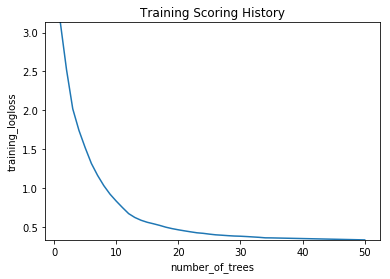

In [69]:
#HDP plot for DRF
mod_best_drf.plot()

In [73]:
#Hyperparamaters for DRF
mod_best_drf.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'DRF_1_AutoML_20190420_095656',
   'type': 'Key<Model>',
   'URL': '/3/Models/DRF_1_AutoML_20190420_095656'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'score_each_iteration': {'default': False, 'actual': False},
 'score_tree_interval': {'default': 0, 'actual': 0},
 'fold_assignment': {'default': 'AUTO

In [ ]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best_drf.params.json'
dict_to_json(mod_best_drf.params,r)

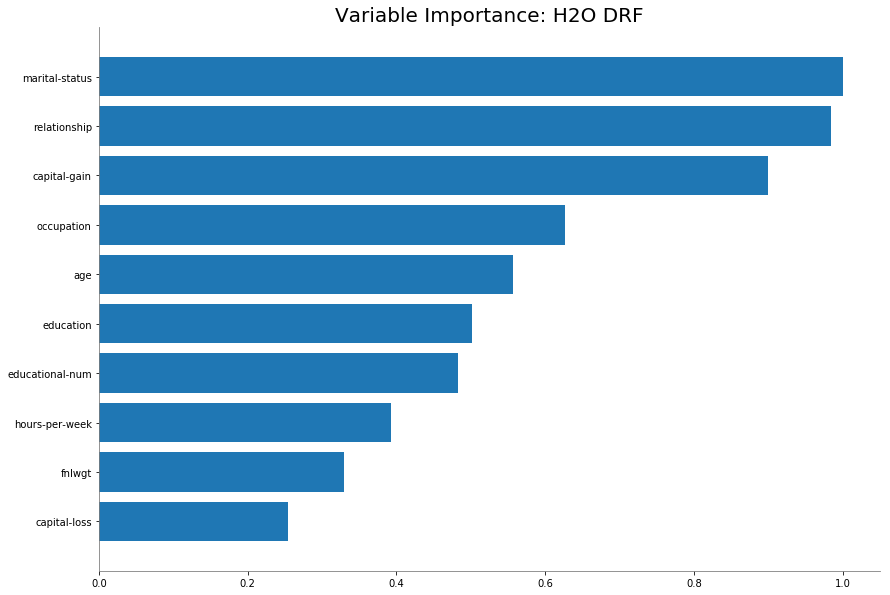

In [90]:
%matplotlib inline
mod_best_drf.varimp_plot()

In [84]:
# Get glm best model  
def get_glm_best(lst):
    se=None
    for model in model_set:
      if 'GLM' in model:
        dl=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return dl 
dl=get_glm_best(model_set)
print(dl)

GLM_grid_1_AutoML_20190420_095656_model_1


In [85]:
if se is not None:
  mod_best_glm=h2o.get_model(dl)
mod_best_glm._id

'GLM_grid_1_AutoML_20190420_095656_model_1'

In [87]:
mod_best_glm.params

{'model_id': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>'},
   'name': 'GLM_grid_1_AutoML_20190420_095656_model_1',
   'type': 'Key<Model>',
   'URL': '/3/Models/GLM_grid_1_AutoML_20190420_095656_model_1'}},
 'training_frame': {'default': None,
  'actual': {'__meta': {'schema_version': 3,
    'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>'},
   'name': 'automl_training_adult.hex',
   'type': 'Key<Frame>',
   'URL': '/3/Frames/automl_training_adult.hex'}},
 'validation_frame': {'default': None, 'actual': None},
 'nfolds': {'default': 0, 'actual': 5},
 'seed': {'default': -1, 'actual': 6996437413272680355},
 'keep_cross_validation_models': {'default': True, 'actual': False},
 'keep_cross_validation_predictions': {'default': False, 'actual': True},
 'keep_cross_validation_fold_assignment': {'default': False, 'actual': False},
 'fold_assignment': {'default': 'AUTO', 'actual': 'Modulo'},
 'fold_c

In [91]:
#To check the hyperparamter values for GLM best model and saving it 
o= run_id+'_mod_best_glm.params.json'
dict_to_json(mod_best_glm.params,o)

In [92]:
# Get XRT best model  
def get_xrt_best(lst):
    xr=None
    for model in model_set:
      if 'XRT' in model:
        xr=model
#     if dr is None:     
#       for model in model_set:
#         if 'AllModels'in model:
#           se=model           
    return xr 
xr=get_xrt_best(model_set)
print(xr)

None


In [93]:
bm=stackedensemble_df(aml_leaderboard_df)

In [94]:
bm

['GBM_2_AutoML_20190420_095656',
 'GLM_grid_1_AutoML_20190420_095656_model_1',
 'DRF_1_AutoML_20190420_095656']

In [95]:

aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_095656,0.928698,0.277266,0.175140,0.296459,0.087888
1,GBM_1_AutoML_20190420_095656,0.928689,0.277315,0.172812,0.296388,0.087846
2,StackedEnsemble_AllModels_AutoML_20190420_095656,0.928677,0.294438,0.178058,0.300674,0.090405
3,StackedEnsemble_BestOfFamily_AutoML_20190420_095656,0.927823,0.295471,0.173396,0.301184,0.090712
4,GBM_3_AutoML_20190420_095656,0.925760,0.286964,0.172997,0.299360,0.089617
5,GBM_4_AutoML_20190420_095656,0.918210,0.359341,0.180514,0.329490,0.108564
6,DRF_1_AutoML_20190420_095656,0.916764,0.309574,0.177295,0.307251,0.094403
7,GLM_grid_1_AutoML_20190420_095656_model_1,0.906625,0.318479,0.197486,0.319092,0.101820
8,GBM_5_AutoML_20190420_095656,0.878062,0.514214,0.212459,0.410379,0.168411


In [96]:
#  Get best_models and coef_norm() of Leader board for GBM
best_models={}
best_models=stackedensemble(mod_best)
bm=[]
if best_models is not None: 
  if 'Intercept' in best_models.keys():
    del best_models['Intercept']
  bm=list(best_models.keys())
else:
  best_models={}
  bm=stackedensemble_df(aml_leaderboard_df)   
  for b in bm:   
    best_models[b]=None

if mod_best.model_id not in bm:
    bm.append(mod_best.model_id)

In [97]:

bm

['GBM_2_AutoML_20190420_095656',
 'GLM_grid_1_AutoML_20190420_095656_model_1',
 'DRF_1_AutoML_20190420_095656']

In [98]:
# Best of Family leaderboard

aml_leaderboard_df=aml_leaderboard_df.loc[aml_leaderboard_df['model_id'].isin(bm)]

In [99]:
aml_leaderboard_df

,model_id,auc,logloss,mean_per_class_error,rmse,mse
0,GBM_2_AutoML_20190420_095656,0.928698,0.277266,0.175140,0.296459,0.087888
6,DRF_1_AutoML_20190420_095656,0.916764,0.309574,0.177295,0.307251,0.094403
7,GLM_grid_1_AutoML_20190420_095656_model_1,0.906625,0.318479,0.197486,0.319092,0.101820


In [100]:
# save leaderboard
leaderboard_stats=run_id+'_leaderboard.csv'
aml_leaderboard_df.to_csv(leaderboard_stats)

In [101]:
#To check the hyperparamter values for best model and saving it 
r= run_id+'_mod_best.params.json'
dict_to_json(mod_best.params,r)

In [102]:
#This will show the model details, model summary and significant variables of Stacked ensemble
mod_best.set_params()

Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_1_AutoML_20190420_095656


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.09519372148223121
RMSE: 0.308534797846582
LogLoss: 0.3357584043256337
Mean Per-Class Error: 0.1720787740179044
AUC: 0.9144059496421585
pr_auc: 0.7012190115315191
Gini: 0.828811899284317
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.36837752074638763: 


,<=50K,>50K,Error,Rate
<=50K,32630.0,4525.0,0.1218,(4525.0/37155.0)
>50K,2833.0,8854.0,0.2424,(2833.0/11687.0)
Total,35463.0,13379.0,0.1506,(7358.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3683775,0.7064550,215.0
max f2,0.1693646,0.7887954,302.0
max f0point5,0.5914927,0.7466136,132.0
max accuracy,0.5414626,0.8659760,148.0
max precision,0.9834013,0.9967320,7.0
max recall,0.0000058,1.0,399.0
max specificity,0.9999780,0.9998654,0.0
max absolute_mcc,0.4805787,0.6135799,170.0
max min_per_class_accuracy,0.2928507,0.8267528,247.0
max mean_per_class_accuracy,0.2521932,0.8279212,266.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.22 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0223988,1.0,4.1600730,4.1600730,0.9954296,1.0,0.9954296,1.0,0.0931805,0.0931805,316.0073014,316.0073014
,2,0.0300152,0.9871138,4.1791734,4.1649198,1.0,0.9949620,0.9965894,0.9987216,0.0318302,0.1250107,317.9173441,316.4919779
,3,0.0400066,0.9479167,4.1020985,4.1492305,0.9815574,0.9667378,0.9928352,0.9907338,0.0409857,0.1659964,310.2098521,314.9230540
,4,0.0500594,0.9166667,3.9919192,4.1176396,0.9551935,0.9340554,0.9852761,0.9793518,0.0401301,0.2061265,299.1919233,311.7639599
,5,0.1000164,0.7586033,3.4752225,3.7967598,0.8315574,0.8329725,0.9084954,0.9062371,0.1736117,0.3797382,247.5222504,279.6759822
,6,0.1500143,0.6231996,2.8477251,3.4804581,0.6814087,0.6901180,0.8328102,0.8342072,0.1423804,0.5221186,184.7725064,248.0458078
,7,0.2000123,0.4980551,2.2607240,3.1755558,0.5409500,0.5595343,0.7598526,0.7655460,0.1130316,0.6351502,126.0724044,217.5555784
,8,0.3000082,0.3309382,1.5830202,2.6447468,0.3787879,0.4053167,0.6328397,0.6454778,0.1582955,0.7934457,58.3020243,164.4746831
,9,0.4000041,0.1969273,0.9797612,2.2285217,0.2344390,0.2637293,0.5332446,0.5500455,0.0979721,0.8914178,-2.0238823,122.8521723
,10,0.5001638,0.0952381,0.6185040,1.9061096,0.1479967,0.1429716,0.4560973,0.4685274,0.0619492,0.9533670,-38.1495999,90.6109561




ModelMetricsBinomial: drf
** Reported on cross-validation data. **

MSE: 0.09440299056154185
RMSE: 0.3072506966005803
LogLoss: 0.3095740420789673
Mean Per-Class Error: 0.1703607129287572
AUC: 0.9167638057470793
pr_auc: 0.768227196291861
Gini: 0.8335276114941585
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.35589445147467286: 


,<=50K,>50K,Error,Rate
<=50K,32405.0,4750.0,0.1278,(4750.0/37155.0)
>50K,2650.0,9037.0,0.2267,(2650.0/11687.0)
Total,35055.0,13787.0,0.1515,(7400.0/48842.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3558945,0.7095077,219.0
max f2,0.1764163,0.7917348,298.0
max f0point5,0.6421531,0.7462668,113.0
max accuracy,0.5309670,0.8657917,151.0
max precision,0.9742944,0.9985896,10.0
max recall,0.0000234,1.0,399.0
max specificity,0.9999069,0.9999462,0.0
max absolute_mcc,0.4340964,0.6169054,187.0
max min_per_class_accuracy,0.2920320,0.8285274,248.0
max mean_per_class_accuracy,0.2838466,0.8296393,252.0


Gains/Lift Table: Avg response rate: 23.93 %, avg score: 24.26 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100323,0.9987097,4.1621156,4.1621156,0.9959184,0.9997942,0.9959184,0.9997942,0.0417558,0.0417558,316.2115590,316.2115590
,2,0.0200033,0.9885733,4.1791734,4.1706183,1.0,0.9948403,0.9979529,0.9973249,0.0416702,0.0834260,317.9173441,317.0618326
,3,0.0300152,0.9701973,4.1706271,4.1706212,0.9979550,0.9793483,0.9979536,0.9913286,0.0417558,0.1251818,317.0627074,317.0621244
,4,0.0400066,0.9415783,4.1020985,4.1535081,0.9815574,0.9573825,0.9938588,0.9828508,0.0409857,0.1661675,310.2098521,315.3508097
,5,0.0500184,0.9093230,3.9996997,4.1227212,0.9570552,0.9261771,0.9864920,0.9715067,0.0400445,0.2062120,299.9699735,312.2721241
,6,0.1000164,0.7588745,3.5151606,3.8190031,0.8411138,0.8284938,0.9138178,0.9000149,0.1757508,0.3819629,251.5160625,281.9003119
,7,0.1500143,0.6168024,2.7946725,3.4776062,0.6687142,0.6882072,0.8321277,0.8294220,0.1397279,0.5216908,179.4672493,247.7606178
,8,0.2000123,0.4964587,2.2915288,3.1811172,0.5483210,0.5549271,0.7611833,0.7608053,0.1145717,0.6362625,129.1528762,218.1117177
,9,0.3000082,0.3299956,1.5864430,2.6495954,0.3796069,0.4050430,0.6339999,0.6422259,0.1586378,0.7949003,58.6442989,164.9595391
,10,0.4000041,0.1983524,1.0165557,2.2413564,0.2432432,0.2626430,0.5363157,0.5473351,0.1016514,0.8965517,1.6555702,124.1356365



Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid,cv_4_valid,cv_5_valid
accuracy,0.8532206,0.0023562,0.8513666,0.8552564,0.851249,0.8587223,0.8495086
auc,0.9167745,0.0022061,0.915791,0.9204813,0.919057,0.9114237,0.9171191
err,0.1467794,0.0023562,0.1486334,0.1447436,0.1487510,0.1412776,0.1504914
err_count,1433.8,23.014778,1452.0,1414.0,1453.0,1380.0,1470.0
f0point5,0.6875877,0.0048289,0.6851346,0.6930353,0.6788892,0.6977047,0.6831749
f1,0.7103657,0.0050518,0.7074940,0.7198890,0.7089926,0.6993464,0.7161066
f2,0.7351058,0.0130852,0.7313619,0.7489077,0.7418895,0.7009958,0.752374
lift_top_group,4.166422,0.0425555,4.162335,4.1376534,4.2249136,4.23581,4.0713987
logloss,0.3095742,0.0060390,0.3091015,0.3048219,0.2981363,0.3239157,0.3118954
max_per_class_error,0.2471773,0.0192502,0.2518108,0.2304108,0.2344291,0.2979003,0.2213356


Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error
,2019-04-20 09:57:28,23.219 sec,0.0,nan,nan,nan,nan,nan,nan
,2019-04-20 09:57:29,23.358 sec,1.0,0.3753489,3.1295043,0.8200621,0.3532915,2.7626877,0.1826891
,2019-04-20 09:57:29,23.484 sec,2.0,0.3654956,2.5216089,0.8347577,0.3854677,2.9590925,0.1865666
,2019-04-20 09:57:29,23.618 sec,3.0,0.3534681,2.0199391,0.8497728,0.4174084,3.1844750,0.1893190
,2019-04-20 09:57:29,23.728 sec,4.0,0.3482982,1.7424509,0.8577107,0.4360697,3.2831440,0.1805761
---,---,---,---,---,---,---,---,---,---
,2019-04-20 09:57:32,26.859 sec,32.0,0.3114751,0.3737139,0.9108099,0.6606114,4.1446128,0.1457148
,2019-04-20 09:57:32,26.980 sec,33.0,0.3111449,0.3687628,0.9113190,0.6656139,4.1434775,0.1458581
,2019-04-20 09:57:32,27.098 sec,34.0,0.3109189,0.3622173,0.9117016,0.6670918,4.1459834,0.1536997
,2019-04-20 09:57:32,27.213 sec,35.0,0.3107700,0.3614397,0.9118134,0.6700087,4.1453111,0.1483150



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
marital-status,33836.9921875,1.0,0.1527913
relationship,33298.8906250,0.9840972,0.1503615
capital-gain,30442.1835938,0.8996717,0.1374620
occupation,21188.2011719,0.6261845,0.0956755
age,18828.1718750,0.5564375,0.0850188
education,16955.2265625,0.5010855,0.0765615
educational-num,16337.6748047,0.4828347,0.0737729
hours-per-week,13286.8710938,0.3926729,0.0599970
fnlwgt,11131.2587891,0.3289671,0.0502633
capital-loss,8581.2060547,0.2536043,0.0387485


In [103]:
top=aml_leaderboard_df.iloc[0]['model_id']
print(top)

GBM_2_AutoML_20190420_095656


In [105]:
mod_best_lead=h2o.get_model(top)
print(mod_best_lead._id)
print(mod_best_lead.algo)

GBM_2_AutoML_20190420_095656
gbm


In [106]:
#To check the hyperparamter values for best model and saving it 
j= run_id+'_mod_best_lead.params.json'
dict_to_json(mod_best_lead.params,j)

In [107]:
meta_data['mod_best']=mod_best._id
meta_data['mod_best_algo']=mod_best.algo
meta_data['mod_best.params'] = mod_best.params
meta_data['mod_best.varimp()'] = mod_best.varimp()


In [108]:
#Variable Imp for GBM
mod_best_lead.varimp()

[('relationship', 6284.44091796875, 1.0, 0.2650741374903254),
 ('capital-gain', 4418.01953125, 0.7030091600698806, 0.1863495467533217),
 ('education', 2881.80859375, 0.45856244515088146, 0.12155304463382455),
 ('marital-status',
  2800.699951171875,
  0.4456561829014878,
  0.11813192829984258),
 ('occupation', 2045.6910400390625, 0.3255167908715527, 0.08628608257889547),
 ('capital-loss',
  1342.2149658203125,
  0.21357746589399743,
  0.056613862559220754),
 ('age', 1213.012451171875, 0.1930183554918269, 0.05116417410179702),
 ('educational-num',
  764.5732421875,
  0.12166129846195205,
  0.032249263755754994),
 ('hours-per-week',
  689.9314575195312,
  0.10978406297795702,
  0.02910091580406552),
 ('native-country',
  557.8959350585938,
  0.08877415546439989,
  0.023531732691157856),
 ('workclass', 381.09259033203125, 0.06064065130159702, 0.016074268340622408),
 ('fnlwgt', 199.96490478515625, 0.031819044429777, 0.008434405757989483),
 ('gender', 68.81172180175781, 0.010949537548361431

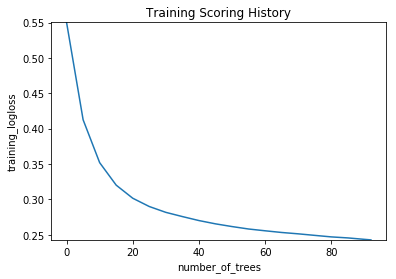

In [109]:
#Plot to see the hyper parameter dependency plot
import matplotlib.pyplot as plt
mod_best_lead.plot()

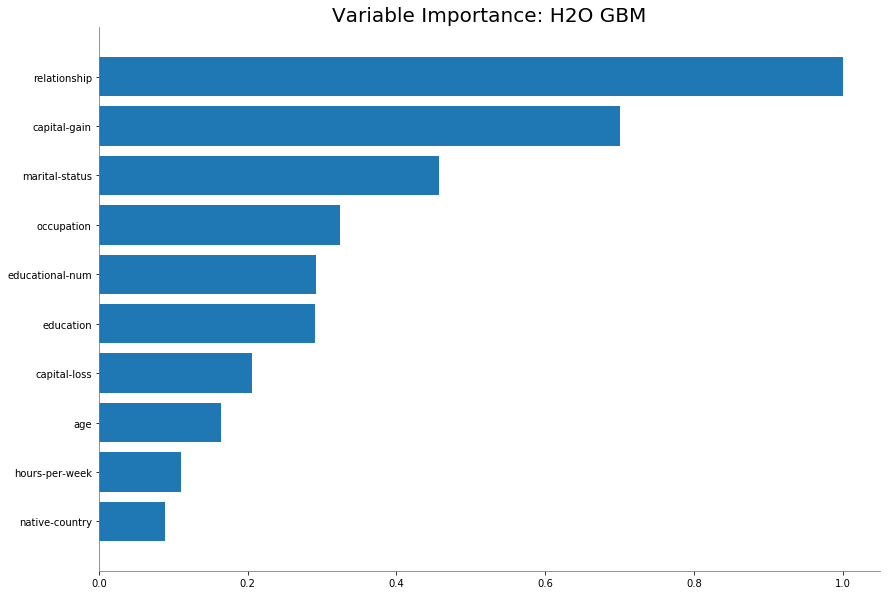

In [832]:
%matplotlib inline
mod_best_lead.varimp_plot()

In [110]:
meta_data['models']=bm

In [111]:
models_path=os.path.join(run_dir,'models')
for mod in bm:
  try:   
    m=h2o.get_model(mod) 
    h2o.save_model(m, path = models_path)
  except:    
    pass

In [112]:
print(models_path)

C:\Users\pkash\mObOrqIpy\models


In [ ]:
# GBM
 
# mod,mod_id=get_model_by_algo("GBM",best_models)
# if mod is not None:
#     try:     
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_gbm_scoring_history.csv') 
#     except:
#         pass   
#     try:     
#         stats_gbm={}
#         stats_gbm=gbm_stats(mod)
#         n=run_id+'_gbm_stats.json'
#         dict_to_json(stats_gbm,n)
#         print(stats_gbm)
#     except:
#         pass

In [113]:
# if mod is not None:
#     try:    
#         sh_df=mod.scoring_history()
#         sh_df.to_csv(run_id+'_dl_scoring_history.csv') 
#     except:
#         pass 
#     try:
#         stats_dl={}
#         stats_dl=dl_stats(mod)
#         n=run_id+'_dl_stats.json'
#         dict_to_json(stats_dl,n)
#         print(stats_dl)
#     except:
#         pass    
#     try:
#         cf=mod.confusion_matrix()    
#         cf_df.to_csv(run_id+'_dl_confusion_matrix.csv')
#     except:
#         pass

In [75]:
# # DRF

# mod,mod_id=get_model_by_algo("DRF",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_drf_scoring_history.csv') 
#     except:
#          pass  
#     try: 
#          stats_drf={}
#          stats_drf=drf_stats(mod)
#          n=run_id+'_drf_stats.json'
#          dict_to_json(stats_drf,n)
#          print(stats_drf)
#     except:
#          pass

In [76]:
# stats_xrt

In [77]:
# XRT

# mod,mod_id=get_model_by_algo("XRT",best_models)
# if mod is not None:
#     try:     
#          sh_df=mod.scoring_history()
#          sh_df.to_csv(run_id+'_xrt_scoring_history.csv')
#     except:
#          pass     
#     try:        
#          stats_xrt={}
#          stats_xrt=xrt_stats(mod)
#          n=run_id+'_xrt_stats.json'
#          dict_to_json(stats_xrt,n)
#          print(stats_xrt)
#     except:
#          pass

In [78]:
# GLM

# mod,mod_id=get_model_by_algo("GLM",best_models)
# if mod is not None:
#     try:     
#          stats_glm={}
#          stats_glm=glm_stats(mod)
#          n=run_id+'_glm_stats.json'
#          dict_to_json(stats_glm,n)
#          print(stats_glm)
#     except:
#          pass

In [114]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions
predictions_df=predictions_test(mod_best,test,run_id)

drf prediction progress: |████████████████████████████████████████████████| 100%


In [115]:

predictions_df.head()

predict,<=50K,>50K
<=50K,0.839303,0.160697
<=50K,0.999973,2.70998e-05
>50K,0.248478,0.751522
<=50K,0.997105,0.00289469
>50K,0.028464,0.971536
>50K,0.544368,0.455632
<=50K,0.999753,0.000246913
<=50K,0.863172,0.136828
>50K,0.616996,0.383004
>50K,0.198348,0.801652


In [116]:
# Update and save meta data

meta_data['end_time'] = time.time()
meta_data['execution_time'] = meta_data['end_time'] - meta_data['start_time']
  
n=run_id+'_meta_data.json'
dict_to_json(meta_data,n)

In [117]:
meta_data

{'start_time': 1555767122.059894,
 'target': None,
 'server_path': 'C:\\Users\\pkash',
 'data_path': 'C:/Users/pkash/Downloads/adult.csv',
 'test_path': None,
 'max_models': 100,
 'run_time': 100,
 'run_id': 'mObOrqIpy',
 'scale': False,
 'classification': False,
 'model_path': None,
 'balance': False,
 'balance_threshold': 0.2,
 'project': None,
 'end_time': 1555773203.1888335,
 'execution_time': 6081.1289393901825,
 'run_path': 'C:\\Users\\pkash\\mObOrqIpy',
 'nthreads': 1,
 'min_mem_size': 6,
 'analysis': 0,
 'x': ['age',
  'workclass',
  'fnlwgt',
  'education',
  'educational-num',
  'marital-status',
  'occupation',
  'relationship',
  'race',
  'gender',
  'capital-gain',
  'capital-loss',
  'hours-per-week',
  'native-country'],
 'variables': {'age': 'int',
  'workclass': 'enum',
  'fnlwgt': 'int',
  'education': 'enum',
  'educational-num': 'int',
  'marital-status': 'enum',
  'occupation': 'enum',
  'relationship': 'enum',
  'race': 'enum',
  'gender': 'enum',
  'capital-gain

In [118]:
# Save logs
h2o.download_all_logs(dirname=logs_path, filename=logfile)

Writing H2O logs to C:\Users\pkash\mObOrqIpy\logs\mObOrqIpy_autoh2o_log.zip


'C:\\Users\\pkash\\mObOrqIpy\\logs\\mObOrqIpy_autoh2o_log.zip'

In [119]:
# Clean up
os.chdir(server_path)

In [120]:
def predictions_test(mod,test,run_id):
    mod_perf=mod_best.model_performance(test)          
    stats_test={}
    stats_test=model_performance_stats(mod_perf)
    print(stats_test)   
    n=run_id+'_test_stats.json'
    dict_to_json(stats_test,n) 
    try:
      cf=mod_perf.confusion_matrix()
      print(cf)   
#      cf=mod_perf.confusion_matrix(metrics=["f1","f2","f0point5","accuracy","precision","recall","specificity","absolute_mcc","min_per_class_accuracy","mean_per_class_accuracy"])
      cf_df=cf.table.as_data_frame()
      print(cf_df)    
      cf_df.to_csv(run_id+'_test_confusion_matrix.csv')
    except:
      pass
    predictions = mod_best.predict(test)    
    predictions_df=test.cbind(predictions).as_data_frame() 
    predictions_df.to_csv(run_id+'_predictions.csv')
    return predictions

In [130]:
# -------------------------------------------------------------
#Grid Search on GBM using hyperparameters from automl run
#--------------------------------------------------------------

gbm_params = {'learn_rate': 0.1,
                'max_depth': 15,
                'sample_rate': 0.8,
                'col_sample_rate': 0.8,
                'max_abs_leafnode_pred' : 2,
                 'balance_classes' : False,
                 'distribution' : "bernoulli",
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': -5971532871064491167, 'stopping_rounds' : 5 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}


               

In [131]:
# Train and validate a cartesian grid of GBMs
gbm_grid = H2OGridSearch(model=H2OGradientBoostingEstimator,
                          grid_id='gbm_grid',
                          hyper_params=gbm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
gbm_grid.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               ntrees = 1)

gbm Grid Build progress: |████████████████████████████████████████████████| 100%


In [157]:
# Get the grid results, sorted by validation AUC
# gbm_gridperf = gbm_grid.get_grid(sort_by=None, decreasing=None)
# gbm_gridperf



In [133]:
# Grab the top GBM model, chosen by validation AUC
best_gbm2 = gbm_gridperf2.models[0]
best_gbm2

Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  gbm_grid_model_1


ModelMetricsBinomial: gbm
** Reported on train data. **

MSE: 0.04577541650895897
RMSE: 0.21395190232610453
LogLoss: 0.16344318620697196
Mean Per-Class Error: 0.024286420037065604
AUC: 0.9966264432214998
pr_auc: 0.9839830113311958
Gini: 0.9932528864429997
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3077336467137082: 


,<=50K,>50K,Error,Rate
<=50K,21263.0,846.0,0.0383,(846.0/22109.0)
>50K,228.0,21891.0,0.0103,(228.0/22119.0)
Total,21491.0,22737.0,0.0243,(1074.0/44228.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3077336,0.9760567,275.0
max f2,0.2245032,0.9866322,298.0
max f0point5,0.4321356,0.9745925,238.0
max accuracy,0.3077336,0.9757167,275.0
max precision,0.9950397,1.0,0.0
max recall,0.1306671,1.0,327.0
max specificity,0.9950397,1.0,0.0
max absolute_mcc,0.3077336,0.9518049,275.0
max min_per_class_accuracy,0.3625672,0.9728165,259.0
max mean_per_class_accuracy,0.3077336,0.9757136,275.0


Gains/Lift Table: Avg response rate: 50.01 %, avg score: 41.61 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100389,0.9937007,1.9995479,1.9995479,1.0,0.9946535,1.0,0.9946535,0.0200732,0.0200732,99.9547900,99.9547900
,2,0.0200099,0.9926719,1.9995479,1.9995479,1.0,0.9931355,1.0,0.9938971,0.0199376,0.0400109,99.9547900,99.9547900
,3,0.0300714,0.9916841,1.9995479,1.9995479,1.0,0.9921839,1.0,0.9933239,0.0201185,0.0601293,99.9547900,99.9547900
,4,0.0400651,0.9906524,1.9995479,1.9995479,1.0,0.9911939,1.0,0.9927926,0.0199828,0.0801121,99.9547900,99.9547900
,5,0.0500588,0.9897391,1.9995479,1.9995479,1.0,0.9901805,1.0,0.9922711,0.0199828,0.1000949,99.9547900,99.9547900
,6,0.1000497,0.9796974,1.9995479,1.9995479,1.0,0.9857666,1.0,0.9890211,0.0999593,0.2000543,99.9547900,99.9547900
,7,0.1500859,0.9303811,1.9995479,1.9995479,1.0,0.9599168,1.0,0.9793182,0.1000497,0.3001040,99.9547900,99.9547900
,8,0.2000543,0.8732655,1.9995479,1.9995479,1.0,0.9007153,1.0,0.9596852,0.0999141,0.4000181,99.9547900,99.9547900
,9,0.3000136,0.7741805,1.9923114,1.9971368,0.9963809,0.8261948,0.9987942,0.9152085,0.1991501,0.5991681,99.2311355,99.7136809
,10,0.3999955,0.6307554,1.9660864,1.9893755,0.9832655,0.7070443,0.9949127,0.8631763,0.1965731,0.7957412,96.6086447,98.9375535




ModelMetricsBinomial: gbm
** Reported on validation data. **

MSE: 0.09612721791322328
RMSE: 0.31004389675209426
LogLoss: 0.3169602740129317
Mean Per-Class Error: 0.16615914491088157
AUC: 0.91992748736957
pr_auc: 0.7963842736747748
Gini: 0.83985497473914
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.22739946748660134: 


,<=50K,>50K,Error,Rate
<=50K,13089.0,1957.0,0.1301,(1957.0/15046.0)
>50K,1026.0,3647.0,0.2196,(1026.0/4673.0)
Total,14115.0,5604.0,0.1513,(2983.0/19719.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.2273995,0.7097402,272.0
max f2,0.0425809,0.7973103,355.0
max f0point5,0.5923709,0.7491089,140.0
max accuracy,0.4597777,0.8677925,184.0
max precision,0.9948243,1.0,0.0
max recall,0.0005716,1.0,399.0
max specificity,0.9948243,1.0,0.0
max absolute_mcc,0.3469938,0.6154067,226.0
max min_per_class_accuracy,0.1551093,0.8329789,299.0
max mean_per_class_accuracy,0.1295228,0.8338409,310.0


Gains/Lift Table: Avg response rate: 23.70 %, avg score: 19.92 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0100411,0.9919326,4.2197732,4.2197732,1.0,0.9934687,1.0,0.9934687,0.0423711,0.0423711,321.9773165,321.9773165
,2,0.0200314,0.9895059,4.2197732,4.2197732,1.0,0.9907327,1.0,0.9921042,0.0421571,0.0845281,321.9773165,321.9773165
,3,0.0300218,0.9863301,4.2197732,4.2197732,1.0,0.9879205,1.0,0.9907120,0.0421571,0.1266852,321.9773165,321.9773165
,4,0.0400122,0.9806339,4.1769328,4.2090767,0.9898477,0.9836956,0.9974651,0.9889601,0.0417291,0.1684143,317.6932828,320.9076655
,5,0.0500025,0.9690894,4.1555127,4.1983747,0.9847716,0.9756262,0.9949290,0.9862960,0.0415151,0.2099294,315.5512660,319.8374721
,6,0.1000051,0.7838644,3.5607011,3.8795379,0.8438134,0.8709922,0.9193712,0.9286441,0.1780441,0.3879735,256.0701089,287.9537905
,7,0.1500076,0.5931203,2.8203149,3.5264636,0.6683570,0.6895088,0.8356998,0.8489323,0.1410229,0.5289964,182.0314925,252.6463578
,8,0.2000101,0.4222704,2.2254382,3.2012072,0.5273834,0.5012911,0.7586207,0.7620220,0.1112776,0.6402739,122.5438180,220.1207229
,9,0.3000152,0.1972899,1.6155825,2.6726657,0.3828600,0.2999015,0.6333671,0.6079818,0.1615664,0.8018404,61.5582525,167.2665661
,10,0.4000203,0.0579717,1.0249855,2.2607456,0.2429006,0.1185177,0.5357505,0.4856158,0.1025037,0.9043441,2.4985470,126.0745613



Scoring History: 


,timestamp,duration,number_of_trees,training_rmse,training_logloss,training_auc,training_pr_auc,training_lift,training_classification_error,validation_rmse,validation_logloss,validation_auc,validation_pr_auc,validation_lift,validation_classification_error
,2019-04-20 11:14:36,0.015 sec,0.0,0.5632248,0.8497116,0.5,0.0,1.0,0.4998869,0.4252472,0.5476142,0.5,0.0,1.0,0.7630204
,2019-04-20 11:14:36,0.244 sec,1.0,0.5427480,0.7891070,0.9417202,0.6527370,1.9885129,0.1421045,0.4087450,0.5097781,0.8887655,0.5034625,3.8861315,0.1692784
,2019-04-20 11:14:36,0.341 sec,2.0,0.5240788,0.7377693,0.9504096,0.9448191,1.9991864,0.1244234,0.3950908,0.4793936,0.9007593,0.7533809,4.1367365,0.1499569
,2019-04-20 11:14:37,0.509 sec,3.0,0.5066087,0.6928498,0.9546630,0.9499561,1.9995479,0.1175952,0.3835133,0.4543939,0.9050366,0.7781611,4.1556429,0.1522390
,2019-04-20 11:14:37,0.627 sec,4.0,0.4900026,0.6527003,0.9581967,0.9536120,1.9995479,0.1111061,0.3736141,0.4335687,0.9082309,0.7837397,4.0956622,0.1515797
---,---,---,---,---,---,---,---,---,---,---,---,---,---,---,---
,2019-04-20 11:14:40,3.842 sec,38.0,0.2852645,0.2605490,0.9837048,0.9808321,1.9995479,0.0618160,0.3052127,0.2986423,0.9210005,0.8089265,4.2197732,0.1431107
,2019-04-20 11:14:40,3.932 sec,39.0,0.2835569,0.2576736,0.9839844,0.9804758,1.9995479,0.0613865,0.3050036,0.2983283,0.9212994,0.8089367,4.2197732,0.1456970
,2019-04-20 11:14:40,4.007 sec,40.0,0.2810746,0.2536695,0.9846666,0.9812643,1.9995479,0.0590802,0.3051990,0.2987882,0.9211156,0.8085896,4.2197732,0.1449871
,2019-04-20 11:14:40,4.091 sec,41.0,0.2802075,0.2517974,0.9847674,0.9812637,1.9995479,0.0590576,0.3049320,0.2982422,0.9214428,0.8092806,4.2197732,0.1423500



See the whole table with table.as_data_frame()
Variable Importances: 


variable,relative_importance,scaled_importance,percentage
relationship,14025.9013672,1.0,0.3102462
occupation,4892.7314453,0.3488354,0.1082249
capital-gain,4641.7177734,0.3309390,0.1026726
age,4210.9375,0.3002258,0.0931439
marital-status,3352.0532227,0.2389902,0.0741458
fnlwgt,2968.4313965,0.2116393,0.0656603
education,2714.6987305,0.1935490,0.0600478
hours-per-week,2345.0236816,0.1671924,0.0518708
educational-num,1638.5026855,0.1168198,0.0362429
workclass,1428.6156006,0.1018555,0.0316003


In [134]:
# Now let's evaluate the model performance on a test set
# so we get an honest estimate of top model performance
best_gbm_perf2 = best_gbm2.model_performance(test)

best_gbm_perf2.auc()

0.91992748736957

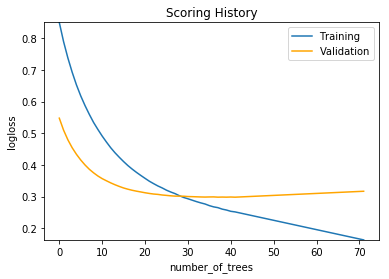

In [135]:
#HDP plot for GBM
import matplotlib.pyplot as plt
best_gbm2.plot()

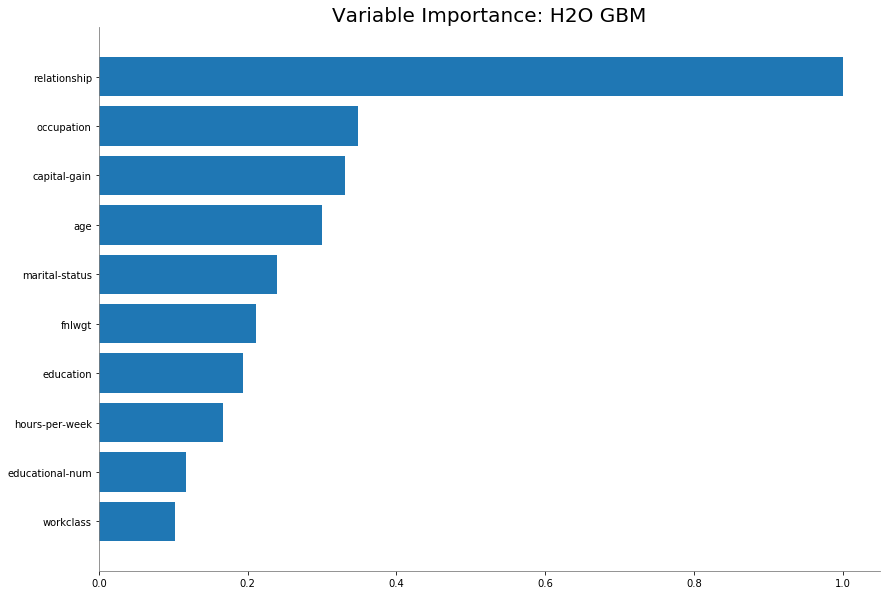

In [136]:
#VIMP plot for GBM
import matplotlib.pyplot as plt
best_gbm2.varimp_plot()

In [137]:
# -------------------------------------------------------------
#Grid Search on DRF using hyperparameters from automl run
#--------------------------------------------------------------

drf_params = {'mtries': -1,
                'categorical_encoding':"Auto",
                'distribution' : "multinomial",
                'sample_rate' : 0.6320000290870667,
                'max_depth': 20
                
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': -1960300359850271237, 'stopping_rounds' : 0 , "max_runtime_secs":0,
                  "stopping_metric": 'logloss', "stopping_tolerance": 0.004524840555912091}



In [141]:
# Train and validate a cartesian grid of DRFs
drf_grid = H2OGridSearch(model=H2ORandomForestEstimator,
                          grid_id='drf_grid',
                          hyper_params=drf_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
drf_grid.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               ntrees = 50)

drf Grid Build progress: |████████████████████████████████████████████████| 100%


In [163]:
# Grab the top DRF model

best_perf_drf = drf_grid.model_performance()

best_perf_drf 


ModelMetricsBinomial: drf
** Reported on train data. **

MSE: 0.0975265080121013
RMSE: 0.31229234382562326
LogLoss: 0.3594461404543062
Mean Per-Class Error: 0.17526715531802195
AUC: 0.9099277166607835
pr_auc: 0.70999169345084
Gini: 0.8198554333215671
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.38708759491460026: 


,<=50K,>50K,Error,Rate
<=50K,19677.0,2432.0,0.11,(2432.0/22109.0)
>50K,1874.0,5140.0,0.2672,(1874.0/7014.0)
Total,21551.0,7572.0,0.1479,(4306.0/29123.0)


Maximum Metrics: Maximum metrics at their respective thresholds



metric,threshold,value,idx
max f1,0.3870876,0.7047854,207.0
max f2,0.1597226,0.7841987,306.0
max f0point5,0.6414455,0.7414884,115.0
max accuracy,0.5111193,0.8623425,160.0
max precision,0.9999848,0.995,0.0
max recall,0.0000004,1.0,399.0
max specificity,0.9999848,0.9998643,0.0
max absolute_mcc,0.4051260,0.6072969,200.0
max min_per_class_accuracy,0.2872655,0.8236384,248.0
max mean_per_class_accuracy,0.2799781,0.8247328,251.0


Gains/Lift Table: Avg response rate: 24.08 %, avg score: 24.44 %



,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
,1,0.0203276,1.0,4.1310832,4.1310832,0.9949324,1.0,0.9949324,1.0,0.0839749,0.0839749,313.1083152,313.1083152
,2,0.0300450,0.9761905,4.0787652,4.1141620,0.9823322,0.9889319,0.9908571,0.9964203,0.0396350,0.1236099,307.8765236,311.4162043
,3,0.0406895,0.9411765,4.0985485,4.1100775,0.9870968,0.9552187,0.9898734,0.9856418,0.0436270,0.1672370,309.8548525,311.0077494
,4,0.0500292,0.9068068,3.9231469,4.0751804,0.9448529,0.9246019,0.9814688,0.9742466,0.0366410,0.2038780,292.3146879,307.5180358
,5,0.1000240,0.7752474,3.4962256,3.7858023,0.8420330,0.8369665,0.9117748,0.9056301,0.1747933,0.3786712,249.6225563,278.5802335
,6,0.1500189,0.6300292,2.7718852,3.4479073,0.6675824,0.7027980,0.8303960,0.8380349,0.1385800,0.5172512,177.1885194,244.7907311
,7,0.2000137,0.4977363,2.2157971,3.1399326,0.5336538,0.5637905,0.7562232,0.7694855,0.1107784,0.6280297,121.5797115,213.9932642
,8,0.3000034,0.3261875,1.5527690,2.6109387,0.3739698,0.4026559,0.6288200,0.6472230,0.1552609,0.7832906,55.2769020,161.0938655
,9,0.3999931,0.2028621,0.9966809,2.2074089,0.2400412,0.2640437,0.5316336,0.5514364,0.0996578,0.8829484,-0.3319059,120.7408870
,10,0.5000172,0.1032443,0.6186138,1.8895844,0.1489873,0.1508787,0.4550886,0.4713084,0.0618762,0.9448246,-38.1386215,88.9584390


{'drf_grid_model_1': }

In [164]:
#Grab the auc of the model

drf_grid.auc()



{'drf_grid_model_1': 0.9099277166607835}

In [193]:
# -------------------------------------------------------------
#Grid Search on GLM using hyperparameters from automl run
#--------------------------------------------------------------

glm_params = {'tweedie_variance_power': 0,
                'tweedie_link_power':1.0,
                
                
                
                'theta' : 1e-10,
                'missing_values_handling': "MeanImputation",
                
                
                'alpha' : [0.0, 0.2, 0.4, 0.6, 0.8, 1.0],
                'lambda' : [14.190629444115807, 8.812621300901148, 5.472787130334066, 3.398693527303556, 2.110646260752699,
                            1.3107470862675006, 0.813996147107118,0.5055053979879761,0.3139274163681697,0.19495424408887968,
                            0.1210698884728571,0.07518645189456613,0.04669206042724046,0.028996560577140867,0.018007355374989435,
                            0.011182872766530513,0.006944753447033205,0.004312809547867441,0.0026783277963773667,0.0016632869374894371,
                            0.0010329293674078712,0.0006414666369376214,0.00039836164919646624,0.0002473893331508685]
                
        
              
        
              }
# Search criteria
search_criteria = {'strategy': 'RandomDiscrete', 'max_models': 100,'seed': 6996437413272680355}



In [194]:
# Train and validate a cartesian grid of glm
glm_grid = H2OGridSearch(model=H2OGeneralizedLinearEstimator,
                          grid_id='glm_grid',
                          hyper_params=glm_params,
                          search_criteria=search_criteria)

#Training Model on the adults.csv data
glm_grid.train(x=x, y=y,
               training_frame=train,
               validation_frame=test,
               )

glm Grid Build progress: |████████████████████████████████████████████████| 100%
Errors/Warnings building gridsearch model

Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.04669206042724046]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentExceptio


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.011182872766530513]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [3.398693527303556]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.011182872766530513]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:2


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.5055053979879761]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.0016632869374894371]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [14.190629444115807]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [2.110646260752699]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.00039836164919646624]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.813996147107118]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.19495424408887968]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:22


Hyper-parameter: alpha, [0.8]
Hyper-parameter: lambda, [0.04669206042724046]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:22


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [0.3139274163681697]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222


Hyper-parameter: alpha, [0.2]
Hyper-parameter: lambda, [0.19495424408887968]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:22


Hyper-parameter: alpha, [0.6]
Hyper-parameter: lambda, [0.04669206042724046]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:22


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [0.0002473893331508685]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [3.398693527303556]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)


Hyper-parameter: alpha, [0.4]
Hyper-parameter: lambda, [1.3107470862675006]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222


Hyper-parameter: alpha, [0.0]
Hyper-parameter: lambda, [5.472787130334066]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:222)


Hyper-parameter: alpha, [1.0]
Hyper-parameter: lambda, [0.0002473893331508685]
Hyper-parameter: missing_values_handling, MeanImputation
Hyper-parameter: theta, 1e-10
Hyper-parameter: tweedie_link_power, 1.0
Hyper-parameter: tweedie_variance_power, 0.0
failure_details: Illegal argument(s) for GLM model: glm_grid_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

failure_stack_traces: water.exceptions.H2OModelBuilderIllegalArgumentException: Illegal argument(s) for GLM model: glm_grid_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

	at water.exceptions.H2OModelBuilderIllegalArgumentException.makeFromBuilder(H2OModelBuilderIllegalArgumentException.java:20)
	at hex.glm.GLM$GLMDriver.computeImpl(GLM.java:1220)
	at hex.ModelBuilder$Driver.compute2(ModelBuilder.java:

ValueError: Illegal argument(s) for GLM model: glm_grid_model_1.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_2.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_3.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_4.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_5.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_6.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_7.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_8.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_9.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_10.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_11.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_12.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_13.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_14.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_15.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_16.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_17.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_18.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_19.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_20.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_21.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_22.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_23.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_24.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_25.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_26.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_27.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_28.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_29.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_30.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_31.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_32.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_33.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_34.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_35.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_36.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_37.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_38.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_39.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_40.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_41.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_42.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_43.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_44.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_45.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_46.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_47.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_48.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_49.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_50.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_51.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_52.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_53.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_54.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_55.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_56.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_57.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_58.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_59.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_60.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_61.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_62.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_63.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_64.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_65.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_66.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_67.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_68.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_69.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_70.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_71.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_72.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_73.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_74.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_75.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_76.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_77.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_78.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_79.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_80.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_81.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_82.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_83.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_84.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_85.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_86.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_87.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_88.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_89.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_90.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_91.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_92.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_93.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_94.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_95.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_96.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_97.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_98.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_99.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2

Illegal argument(s) for GLM model: glm_grid_model_100.  Details: ERRR on field: _response: Regression requires numeric response, got categorical.

For more information visit:
  http://jira.h2o.ai/browse/TN-2



In [ ]:
# h2o.cluster().shutdown()